# CONVEX HETEROGENEITY DETECTION

Notebooks contains code version for Google Collab

In [0]:
import torch

import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
from torchsummary import summary

import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt
import numpy as np
import time
from tqdm import tqdm_notebook as tqdm

import os
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

The dataset is stored on my dropbox (share link in the cell below)

In [0]:
!wget https://www.dropbox.com/s/izk9m32vthbtiv3/seismograms.zip?dl=0
!mv seismograms.zip\?dl\=0 seismograms.zip
!unzip seismograms.zip

In [0]:
### Global hyperparameters for the CNN

# Path to a directory with dataset and subfolders for training and validation

DATA_PATH = os.path.join(os.getcwd(), "seismograms") # PATH TO THE DATASET

EPOCH_NUM =  30       # Epochs
BATCH_SIZE = 256      # Batch size
EMBEDDING_SIZE = 1681 # Embedding size for CNN

In [0]:
import re

class SeismogramDataset(Dataset):
    """
    Seismogram dataset.
    Format for seismogram data is 'csv'
    The root directory should contain 'data' and 'grid' folders, with seismograms
    in the first and grids in the second respectively
    Names of the files must contain numerals, due to the indexing issues
    File with the least numeral is considered to be a 'head' of the dataset
    
    """

    def __init__(self, root_dir, transform=None):
        """
        
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir    = os.path.join(os.getcwd(), root_dir)
        self.data_dir    = os.path.join(self.root_dir, 'data')
        self.grid_dir    = os.path.join(self.root_dir, 'grid')
        self.transform   = transform
        
        self.dir_content_data = [] #list with all seismogram filenames
        for file in os.listdir(self.data_dir):
            self.dir_content_data.append(
                (file, re.findall(r'(\d+)', file)[-1]))
        self.dir_content_data = [
            x[0] for x in list(sorted(self.dir_content_data, key= lambda x: x[1]))]
        
        self.dir_content_grid = [] #list with all grid filenames
        for file in os.listdir(self.grid_dir):
            self.dir_content_grid.append(
                (file, re.findall(r'(\d+)', file)[-1]))
        self.dir_content_grid = [
            x[0] for x in list(sorted(self.dir_content_grid, key= lambda x: x[1]))]

    def __len__(self):
        return len(self.dir_content_data)

    def __getitem__(self, idx):
        """
        Method allows to do 'online' loading from disk
        
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        seismo_name = os.path.join(self.data_dir,
                                self.dir_content_data[idx])
        grid_name   = os.path.join(self.grid_dir,
                                self.dir_content_grid[idx])
        data = np.genfromtxt(seismo_name, delimiter=",")
        data = (data - np.mean(data)) / np.std(data)
        grid = 1 - np.genfromtxt(grid_name  , delimiter=",")
        
        if self.transform:
            data = self.transform(data)
        result = {'data': data, 'grid': grid} 
        return result

In [0]:
transformer = transforms.Compose([
    transforms.Lambda(lambda x: torch.from_numpy(x).view(1, x.shape[0], x.shape[1]))
])

train_dataset = SeismogramDataset(
    os.path.join(DATA_PATH, 'train/'), transform=transformer)

val_dataset = SeismogramDataset(
    os.path.join(DATA_PATH, 'val/'), transform=transformer)

n_train, n_val = len(train_dataset), len(val_dataset)

In [0]:
def BatchToTensor(batch):
    """
    Convert a batch of dicts into the dict of batches 
    """
    batch_data, batch_grid = [], []
    for item in batch:
        batch_data.append(item['data'])
        batch_grid.append(item['grid'])
    
    batch_data = torch.from_numpy(np.stack(batch_data))
    batch_grid = torch.from_numpy(np.stack(batch_grid))
        
    return {'data': batch_data, 'grid': batch_grid}

train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE,
    shuffle=True,  collate_fn=BatchToTensor
)

val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, collate_fn=BatchToTensor,
    batch_size=BATCH_SIZE)

### Let's have a look on the preprocessed seismogram data

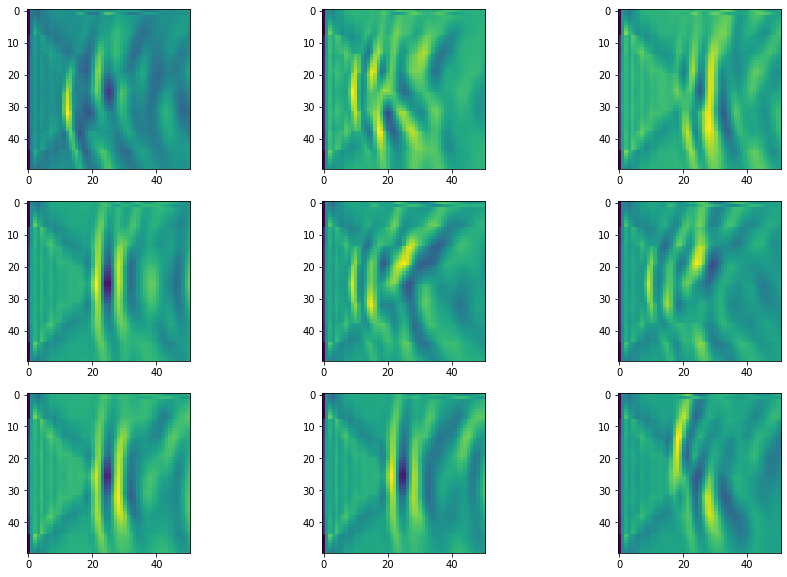

In [12]:
def plot_from_batch_generator(batch_gen):
    data_batch = next(iter(batch_gen))
    grid_size = (3, 3)
    f, axarr = plt.subplots(*grid_size)
    f.set_size_inches(15,10)
    for i in range(grid_size[0] * grid_size[1]):
        axarr[i // grid_size[0], i % grid_size[0]].imshow(data_batch['data'][i][0])
        
plot_from_batch_generator(train_batch_gen)

### Loss function for training is an asymmetric binary cross entropy

I also use learning rate reduction by the factor 0.5 on plateaus

In [0]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from IPython.display import clear_output


def loss(preds, labels):
    sm    = torch.nn.Sigmoid()
    preds = sm(preds)
     
    return torch.sum((-1) * (
        3. * labels * torch.log(preds) + (1 - labels) * torch.log(1. - preds)
    )) / preds.shape[0]


def train_model(
    model, train_batch_generator, val_batch_generator, opt, 
    ckpt_name=None, n_epochs=EPOCH_NUM):
    """
    Train a CNN model
    :params opt - optimizer
    :params cktp_name - name of the checkpoint file
    :params n_epochs - number of epochs
    
    """
    
    train_loss, val_loss = [], [] # arrays for loss history over the batch
    loss_history_train, loss_history_val = [], [] # arrays for loss history over the epoch
    
    model = model.to(device)
    
    #loss = nn.MSELoss(reduction='mean')
    # adjust the lr on the plateau
    lr_scheduler = ReduceLROnPlateau(opt, patience=5, factor=0.3, verbose=True) 
    
    top_val_loss_value = np.inf
    
    for epoch in range(n_epochs):
        start_time = time.time()
        
        
        model.train(True) # enable dropout / batch_norm training behavior
        for batch in tqdm(train_batch_generator, desc='Training'):
            
            X_batch = batch['data'].to(device)
            y_batch = batch['grid'].to(device)
            
            opt.zero_grad()
            preds_train = model.forward(X_batch)
            loss_train  = loss(preds_train, y_batch)
            #raise NotImplementedError
            loss_train.backward()
            opt.step()
            
            train_loss.append(loss_train.cpu().data.numpy())
        
        # Evaluation phase
        model.train(False) # disable dropout / use averages for batch_norm
        for batch in tqdm(val_batch_generator, desc='Validation'):
            
            X_batch = batch['data'].to(device)
            y_batch = batch['grid'].to(device)
            preds_test = model.forward(X_batch)
            loss_test  = loss(preds_test, y_batch)
            val_loss.append(loss_train.cpu().data.numpy())

        
        train_loss_value = np.mean(train_loss[-n_train // BATCH_SIZE :])
        val_loss_value  = np.mean(val_loss[-n_val // BATCH_SIZE :])
        
        lr_scheduler.step(val_loss_value)
        
        loss_history_train.append(train_loss_value)
        loss_history_val.append(val_loss_value)
        
        if val_loss_value < top_val_loss_value and ckpt_name is not None:
            top_val_loss_value = val_loss_value
            with open(ckpt_name, 'wb') as f: torch.save(model, f)
        
        clear_output(True)
        plt.figure(figsize=(12, 8))
        plt.plot(loss_history_train, label='train')
        plt.plot(loss_history_val,     label='val')
        plt.grid(True)
        plt.legend()
        if epoch: plt.show()
            
        # print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, n_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss_value))
        print("  validation loss (in iteration): \t\t\t{:.6f} ".format(val_loss_value))
        
        
        
    return model, opt

### Demonstrational model is a typical LeNet-like CNN with 6 convolutional layers and 3 FC layers

In [0]:
class HETNet(torch.nn.Module):

    def __init__(self, 
                 activation='ReLU',
                 pooling='max',
                 use_batch_norm=True):
      
        super(HETNet, self).__init__()
        
        self.use_batch_norm = use_batch_norm
        
        if activation == 'ReLU':
            activation_function  = nn.ReLU()
        elif activation == 'LeakyReLU':
            activation_function  = nn.LeakyReLU()
        else:
            raise NotImplementedError
            
        if pooling == 'max':
            pooling_layer = nn.MaxPool2d(kernel_size=2, stride=2)
        else:
            raise NotImplementedError
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=0),
            activation_function,
            nn.BatchNorm2d(16),
            pooling_layer,
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            activation_function,
            nn.BatchNorm2d(32),
            pooling_layer
        )
               
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            activation_function,
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            activation_function,
            nn.BatchNorm2d(128),
            pooling_layer
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            activation_function,
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            activation_function,
            nn.BatchNorm2d(512)
        )
        
        self.fc1 = nn.Sequential(
            nn.Linear(6 * 6 * 512, 2048),
            activation_function,
            nn.BatchNorm1d(2048)
            #nn.Dropout(0.5)
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(2048, 1536),
            activation_function,
            nn.BatchNorm1d(1536)
            #nn.Dropout(0.5)
        )

        self.fc3 = nn.Sequential(
            nn.Linear(1536, 1024),
            activation_function,
            nn.BatchNorm1d(1024)
            #nn.Dropout(0.5)
        )
            
        self.fc4 = nn.Linear(1024, EMBEDDING_SIZE)
    
    def forward(self, x):

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        
        return x

### For trainig I use Adam optimizer with learning rate 1e-3 and weight decay 0.1

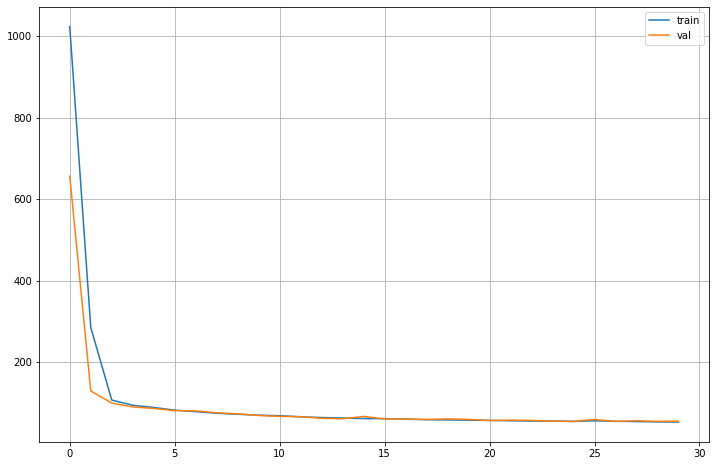

Epoch 30 of 30 took 99.202s
  training loss (in-iteration): 	53.116096
  validation loss (in iteration): 			55.256083 


In [19]:
hetnet = HETNet(activation='LeakyReLU').double()
optimizer = torch.optim.Adam(hetnet.parameters(), lr=1e-3, weight_decay=0.1)
best_model, _= train_model(
    hetnet, train_batch_gen, val_batch_gen, optimizer, 
    n_epochs = EPOCH_NUM, ckpt_name='HETNET_LIGHT.pth'
)

In [0]:
hetnet.train(False)

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

#### Left picture is the prediction of NN, right is the original surface

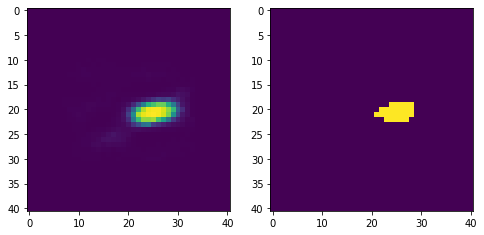

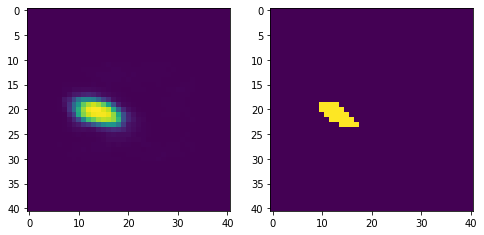

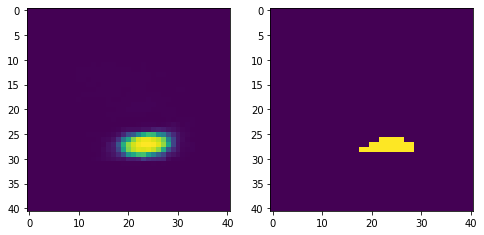

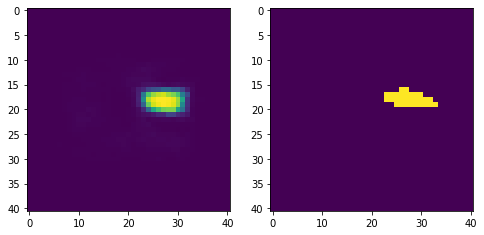

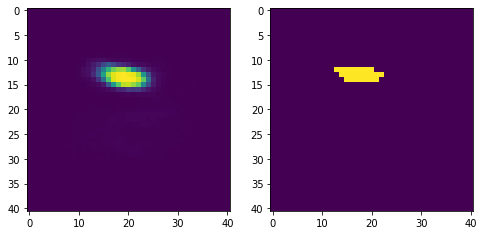

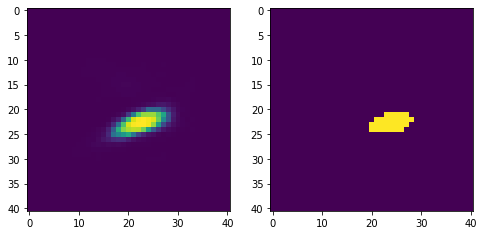

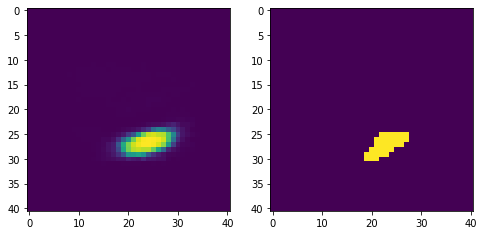

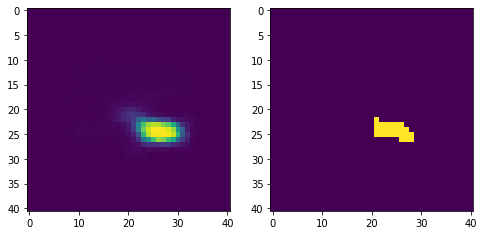

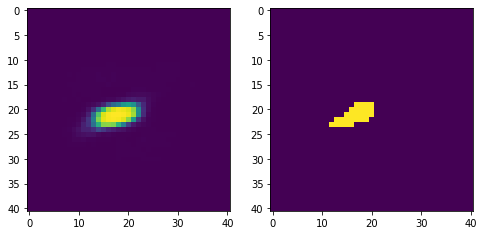

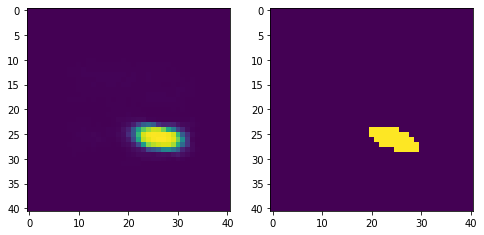

In [25]:
data_batch = next(iter(val_batch_gen))
data = data_batch['data'].to(device)
s = torch.nn.Sigmoid()
pred = s(hetnet.forward(data))
for i in np.random.randint(0, BATCH_SIZE, 10):
    f, axarr = plt.subplots(1, 2, figsize=(8, 9))
    axarr[0].imshow(pred[i].data.cpu().numpy().reshape(41, 41))
    axarr[1].imshow(data_batch['grid'][i].data.reshape(41, 41))